<font color="Teal" face="Comic Sans MS,arial">
  <h1 align="center"><i>Tarea 1</i></h1>
  </font>
  <font color="Black" face="Comic Sans MS,arial">
  <h5 align="center"><i>Monserrat Herrera Hernández</i></h5>
  <h5 align="center"><i>Materia: Proyecto II</i></h5>
  </font>








# Clasificación binaria con redes neuronales.

**Objetivo**: Poder determinar si un sujeto tuvo o no, un ataque epileptico.

##Contexto:
Se presenta una base de datos de 500 personas distintas  con una grabación de la actividad cerebral durante 23,6 segundos.  
La serie de tiempo correspondiente se muestrea en 4097 puntos de datos donde cada punto de datos es el valor del registro de EEG (electroencefalograma) en un momento diferente. Así que tenemos un total de 500 individuos y cada uno tiene 4097 puntos de datos durante 23,5 segundos.

Se dividieron y mezclaron cada 4097 puntos en paquetes de 23, cada paquete tiene 178 puntos de datos durante un segundo, por lo que tenemos entonces $23\times500=11500$ paquetes de información (las filas) cada paquete con 178 puntos por segunto (columnas), la ultima columna es la variable respuesta y representa alguna etiqueta del conjunto {1,2,3,4,5} donde:


*   1: Registro de la convulsión actividad
*   2: Registran el EEG del área donde se encontraba el tumor.
* 3: Si identifican dónde estaba la región del tumor en el cerebro y registran la actividad del EEG del área cerebral sana.
* 4: Ojos cerrados, significa cuando estaban registrando la señal EEG el paciente tenía los ojos cerrados.
* 5: Ojos abiertos, significa que cuando estaban registrando la señal EEG del cerebro, el paciente tenía los ojos abiertos.

Entonces la variable respuesta es la columna 179 con 178 variables explicativas.

Todos los sujetos que pertenecen a las clases 2, 3, 4 y 5 son sujetos que no sufrieron ataques epilépticos. Solo los sujetos de la clase 1 tienen ataques epilépticos.

Fuente: https://www.kaggle.com/chaditya95/epileptic-seizures-dataset





Para esta primer tarea vamos a hacer suposiciones grandes, en primer instancia supondremos que cada columna es independiente de la otra, es decir, aunque 23 columnas correspondan a un mismo paciente en segundos diferentes se pensaran como 23 pacientes distintos.

Por lo que en lugar de 500 personas, tendremos 11500.


In [ ]:
#----Importamos las librerias que utilizaremos----#
#===========================================#
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#-------Cargamos los datos
df=pd.read_csv("/content/data.csv", encoding = "ISO-8859-1") 

#-------Para tener un poco de informacion del archivo, como la dimension.
df.info #---Tenemos 11500 filas y 180 columnas.
#-------Mostramos los primeros 5 registros del archivo
df.head() #Mostramos las primeras 5 filas de nuestro data frame.

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [ ]:
#Etiquetas de respuesta
clases = np.sort(df['y'].unique())
clases

array([1, 2, 3, 4, 5])

##Analisis exploratorio de datos

Veamos la distribución de clases.

In [ ]:
#No es necesario codificar la variable respuesta porque en la columna y de respuesta, ya la tenemos.

#identificamos cuantas observaciones hay de cada clase

print("Número de observaciones por clase")
print(df['y'].value_counts())
print("")

print("Porcentaje de observaciones por clase")
print(100 * df['y'].value_counts(normalize=True))

Número de observaciones por clase
5    2300
4    2300
3    2300
2    2300
1    2300
Name: y, dtype: int64

Porcentaje de observaciones por clase
5    20.0
4    20.0
3    20.0
2    20.0
1    20.0
Name: y, dtype: float64


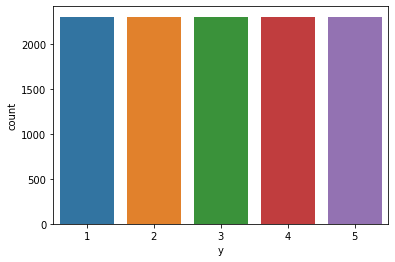

In [ ]:
sns.countplot (x = 'y', data = df)

Sin embargo, la clase que nos interesa es solo la clase 1, pues es la que nos indica si hubo un registro de convulsion epileptica. Por lo que juntaremos el resto en una sola clase.


In [ ]:
df ['y'] = df ['y']. astype ('float64')
encode_map = { 
    2: 0, 
    3: 0, 
    4: 0,
    5: 0
} 

df ['y']. replace (encode_map, inplace = True)

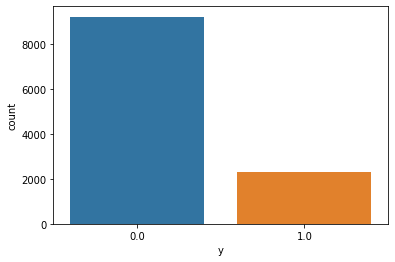

In [ ]:
#Para ver que ya tengamos solo 2 respuestas, donde 0 es que no hay ataque y 1 que si.
sns.countplot (x = 'y', data = df) 

In [ ]:
#Datos de entrada y datos de salida.
X = df.iloc [:, 1: -1] 
y = df.iloc [:, -1]

#print(X)
#print(y)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
#df.head()

In [ ]:
clases = np.sort(df['y'].unique())
clases

array([0., 1.])

In [ ]:
#No es practico por la cantidad de datos de entrada
#%matplotlib inline
#df.hist(figsize=[180,100])
#plt.show()

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
#plotCorrelationMatrix(df, 30)

Dividimos el *dataframe* `df` en `training_data` ($\% 80$) y `test_data` ($\%20$), 

$$\mathcal{X} = \mathcal{X}_{train} \cup \mathcal{X}_{test}$$
$$C = C_{train} \cup C_{test}$$

In [ ]:
msk = np.random.rand(len(df)) < 0.8
training_data = df[msk]
test_data = df[~msk]


#len(training_data) 
#len(test_data) 

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=21)

## Estandarizando la entrada


Para que las redes neuronales se entrenen correctamente necesitamos estandarizar los valores de entrada.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##Media y desviación estándar de los datos de entrenamiento

In [ ]:
X_train = training_data.drop('y', axis=1)
mean_data = X_train.mean(axis=0)
mean_data

X1     -12.300227
X2     -11.444059
X3     -10.628506
X4      -9.437886
X5      -8.173616
          ...    
X174   -14.096827
X175   -14.243474
X176   -14.105058
X177   -13.741579
X178   -13.159428
Length: 178, dtype: float64

In [ ]:
std_data = X_train.std(axis=0)
std_data

X1      162.523967
X2      162.338793
X3      160.207110
X4      158.975015
X5      159.550698
           ...    
X174    167.913200
X175    163.045970
X176    161.906470
X177    163.446248
X178    167.351942
Length: 178, dtype: float64

## Parametros del modelo

Para entrenar al modelo, necesitamos establecer algunos hiperparámetros. Tengamos en cuenta que esta será una red neuronal muy simple, como resultado, no ajustamos muchos hiperparámetros. El objetivo es conocer cómo funciona PyTorch.

In [ ]:
EPOCHS = 50
BATCH_SIZE = 64 
LEARNING_RATE = 0.001

In [ ]:
from torch.utils.data import Dataset

class DataframeDataset(Dataset):

  def __init__(self, data, y_name, transform=None, target_transform=None):
    '''
      data: pandas.DataFrame
    '''
    #self.data = torch.from_numpy(data.to_numpy()).to(dtype=torch.float32)
    self.Y = torch.tensor(data[y_name].to_numpy(), dtype=torch.long)
    aux = data.drop(y_name, axis=1).to_numpy()
    self.X = torch.from_numpy(aux).to(dtype=torch.float32)
    self.transform = transform
    self.target_transform = target_transform 

  def __len__(self):
    return self.Y.size()[0]

  def __getitem__(self, idx):
    x = self.X[idx, :]
    y = self.Y[idx]
    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)
    return x, y

In [ ]:
tx = lambda x: (x - torch.tensor(mean_data, dtype=torch.float32))/torch.tensor(std_data, dtype=torch.float32)
#ty = lambda y: y - torch.tensor(3, dtype=torch.long)

In [ ]:
#train_dataset = DataframeDataset(training_data, y_name='y', transform=tx)
#test_dataset = DataframeDataset(test_data, y_name='y', transform=tx)

In [ ]:
train_loader = DataLoader(dataset=X_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

## Validación

In [ ]:
evens = list(range(0, len(test_data), 2))
odds = list(range(1, len(test_data), 2))
val_dataset = torch.utils.data.Subset(test_data, evens)
test_dataset = torch.utils.data.Subset(test_data, odds)

In [ ]:
n_train = len(train_dataset)
n_train

9235

In [ ]:
n_val = len(val_dataset)
n_val

1134

In [ ]:
n_test = len(test_dataset)
n_test

1133

## Data Loarder


In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 178])
Labels batch shape: torch.Size([64])


Sofmax

In [ ]:
softmax = torch.nn.Softmax(dim=1)
x = torch.rand(1, 3)
y = softmax(x)
print(x)
print(y)
print(torch.sum(y, dim=1))

tensor([[0.6938, 0.7081, 0.6665]])
tensor([[0.3347, 0.3396, 0.3257]])
tensor([1.])


---

## Definimos red neuronal


In [ ]:
#n_features = n_features -1 
#n_clases = len(clases)
#N = [64, 64]

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self, n_features):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(178, 128) 
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) # 178 -> 128
        x = self.batchnorm1(x) # 128 -> 128
        x = self.relu(self.layer_2(x)) # 128 -> 64
        x = self.batchnorm2(x) 
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model = binaryClassification(178)
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


binaryClassification(
  (layer_1): Linear(in_features=178, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Entrenando modelo

Antes de comenzar el entrenamiento real, definamos una función para calcular la precisión.
En la función siguiente, tomamos la salida prevista y real como entrada. El valor predicho (una probabilidad) se redondea para convertirlo en 0 o 1 .
Una vez hecho esto, simplemente comparamos el número de 1/0 que predijimos con el número de 1/0 realmente presente y calculamos la precisión.



In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
  start_time = time.time()
  epoch_loss = 0
  epoch_acc = 0
  for X_batch, y_batch in train_dataloader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device).to(torch.float32)
    optimizer.zero_grad()
          
    y_pred = model(X_batch)

    loss = criterion(y_pred, y_batch.unsqueeze(1))
    acc = binary_acc(y_pred, y_batch.unsqueeze(1))
              
    loss.backward()
    optimizer.step()
              
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  print(f'Epoca {e+0:03}: | Perdida: {epoch_loss/len(train_dataloader):.5f} | Precision: {epoch_acc/len(train_dataloader):.3f}')

Epoca 001: | Perdida: 0.21289 | Precision: 94.510
Epoca 002: | Perdida: 0.11274 | Precision: 96.586
Epoca 003: | Perdida: 0.09378 | Precision: 97.014
Epoca 004: | Perdida: 0.08581 | Precision: 96.938
Epoca 005: | Perdida: 0.06725 | Precision: 97.407
Epoca 006: | Perdida: 0.06554 | Precision: 97.538
Epoca 007: | Perdida: 0.05656 | Precision: 97.917
Epoca 008: | Perdida: 0.05382 | Precision: 98.007
Epoca 009: | Perdida: 0.04982 | Precision: 98.145
Epoca 010: | Perdida: 0.04238 | Precision: 98.517
Epoca 011: | Perdida: 0.03766 | Precision: 98.634
Epoca 012: | Perdida: 0.04006 | Precision: 98.310
Epoca 013: | Perdida: 0.03502 | Precision: 98.600
Epoca 014: | Perdida: 0.03517 | Precision: 98.600
Epoca 015: | Perdida: 0.03669 | Precision: 98.503
Epoca 016: | Perdida: 0.03247 | Precision: 98.690
Epoca 017: | Perdida: 0.03327 | Precision: 98.697
Epoca 018: | Perdida: 0.02814 | Precision: 98.869
Epoca 019: | Perdida: 0.02477 | Precision: 99.145
Epoca 020: | Perdida: 0.02508 | Precision: 98.986


Prueba del modelo

Ya no me quedo la prueba :c me marco un error que no supe como solucionar, lo siento.


In [ ]:
'''y_pred_list = []

model.eval()
with torch.no_grad():  #reduce uso de memoria y acelera el calculo
    for X_batch in test_dataloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]'''

'y_pred_list = []\n\nmodel.eval()\nwith torch.no_grad():  #reduce uso de memoria y acelera el calculo\n    for X_batch in test_dataloader:\n        X_batch = X_batch.to(device)\n        y_test_pred = model(X_batch)\n        y_test_pred = torch.sigmoid(y_test_pred)\n        y_pred_tag = torch.round(y_test_pred)\n        y_pred_list.append(y_pred_tag.cpu().numpy())\n\ny_pred_list = [a.squeeze().tolist() for a in y_pred_list]'

In [ ]:
#print(y_pred_list)

[]


In [ ]:
#print(classification_report(y_test, y_pred_list))